## LinkedIn Data Analysis

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

Opening the excel file and seeing all the sheet names

In [31]:
xls = pd.ExcelFile('LinkedInDataExport.xlsx')
print(xls.sheet_names)

['Connections', 'Messages']


### `Connections Sheet`

In [45]:
connections = pd.read_excel('LinkedInDataExport.xlsx', sheet_name = "Connections")

Dropping some unnecessary columns and combining `first name + last name`

In [46]:
connections["Full Name"] = connections["First Name"].fillna('') + " " + connections["Last Name"].fillna('')
connections = connections.drop(columns=['First Name','Last Name','Email Address','URL'])

Parsing date and extracting time features

In [47]:
connections["Connected On"] = pd.to_datetime(connections["Connected On"], errors = "coerce")

connections["Connected On"] = connections["Connected On"].dt.tz_localize(None)

connections["Year"] = connections["Connected On"].dt.year
connections["Month"] = connections["Connected On"].dt.to_period("M").astype(str)
connections["Quarter"] = connections["Connected On"].dt.to_period("Q").astype(str)
connections.head()

,Company,Position,Connected On,Full Name,Year,Month,Quarter
0,Unified Mentor Private Limited,Business Analyst Intern,2025-09-15,Tanmeet Jabbal,2025,2025-09,2025Q3
1,Equifax,Data Analyst 1,2025-09-15,Vishal MS,2025,2025-09,2025Q3
2,NaN,NaN,2025-09-14,Mehak Walia,2025,2025-09,2025Q3
3,NITI Aayog Official,Intern,2025-09-14,Rohit Ratnoo,2025,2025-09,2025Q3
4,Beyond Codes Inc.,Data and Research Analyst,2025-09-13,Tanya Modgil,2025,2025-09,2025Q3


Saving the cleaned `Connections Sheet`

In [48]:
connections.to_csv("linkedin_connections_clean.csv", index=False)

### `Messages` Sheet

In [76]:
messages = pd.read_excel('LinkedInDataExport.xlsx', sheet_name="Messages")

Dropping unnecessary columns

In [77]:
messages = messages.drop(columns=['CONVERSATION TITLE','SENDER PROFILE URL','RECIPIENT PROFILE URLS','SUBJECT','FOLDER'])

Parsing the date

In [78]:
messages["DATE"] = pd.to_datetime(messages["DATE"], errors="coerce")

messages["DATE"] = messages["DATE"].dt.tz_localize(None)

Extracting time features

In [79]:
messages["Year"] = messages["DATE"].dt.year
messages["Month"] = messages["DATE"].dt.to_period("M").astype(str)
messages["Weekday"] = messages["DATE"].dt.day_name()
messages["Hour"] = messages["DATE"].dt.hour

Getting the message length

In [80]:
messages["Message Length"] = messages["CONTENT"].astype(str).str.len()

Labeling `Sent` vs `Received`

In [81]:
your_name = "Harshdeep Singh"
messages["Direction"] = messages["FROM"].apply(lambda x: "Sent" if your_name.lower() in str(x).lower() else "Received")

messages.head()

,FROM,TO,DATE,CONTENT,Year,Month,Weekday,Hour,Message Length,Direction
0,Aakash Sati,Harshdeep Singh,2025-09-14 12:31:58,No problem,2025,2025-09,Sunday,12,10,Received
1,Harshdeep Singh,Aakash Sati,2025-09-14 03:34:47,"got it, thank you so much aakash for guiding me",2025,2025-09,Sunday,3,47,Sent
2,Aakash Sati,Harshdeep Singh,2025-09-13 16:47:24,i got my acceptance letter 3-4 weeks prior my ...,2025,2025-09,Saturday,16,70,Received
3,Aakash Sati,Harshdeep Singh,2025-09-13 16:46:52,yes start cold emailing to the mail id's i sha...,2025,2025-09,Saturday,16,55,Received
4,Harshdeep Singh,Aakash Sati,2025-09-13 07:42:39,shall i send them a cold email for my nov mont...,2025,2025-09,Saturday,7,62,Sent


Saving the cleaned `Messages Sheet`

In [82]:
messages.to_csv("linkedin_messages_clean.csv", index=False)

### Some Visualizations

Connections over time

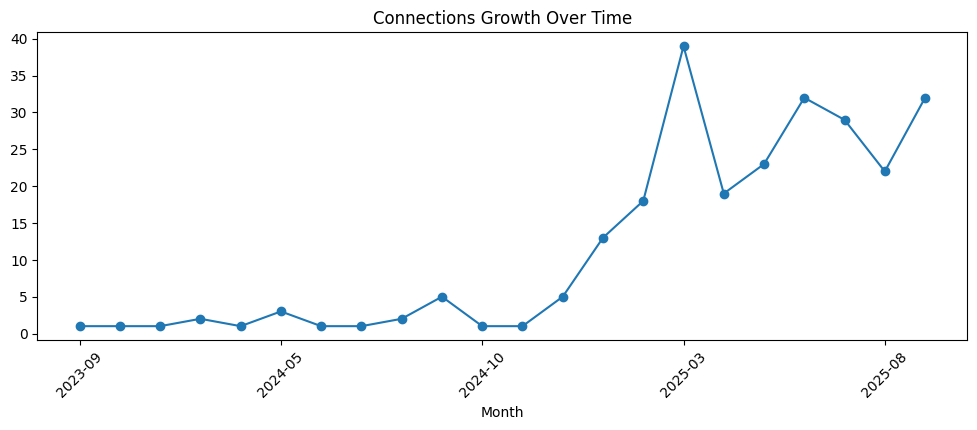

In [83]:
connections_per_month = connections.groupby("Month").size()

plt.figure(figsize=(12,4))
connections_per_month.plot(marker="o")
plt.title("Connections Growth Over Time")
plt.xticks(rotation=45)
plt.show()


Top 10 companies

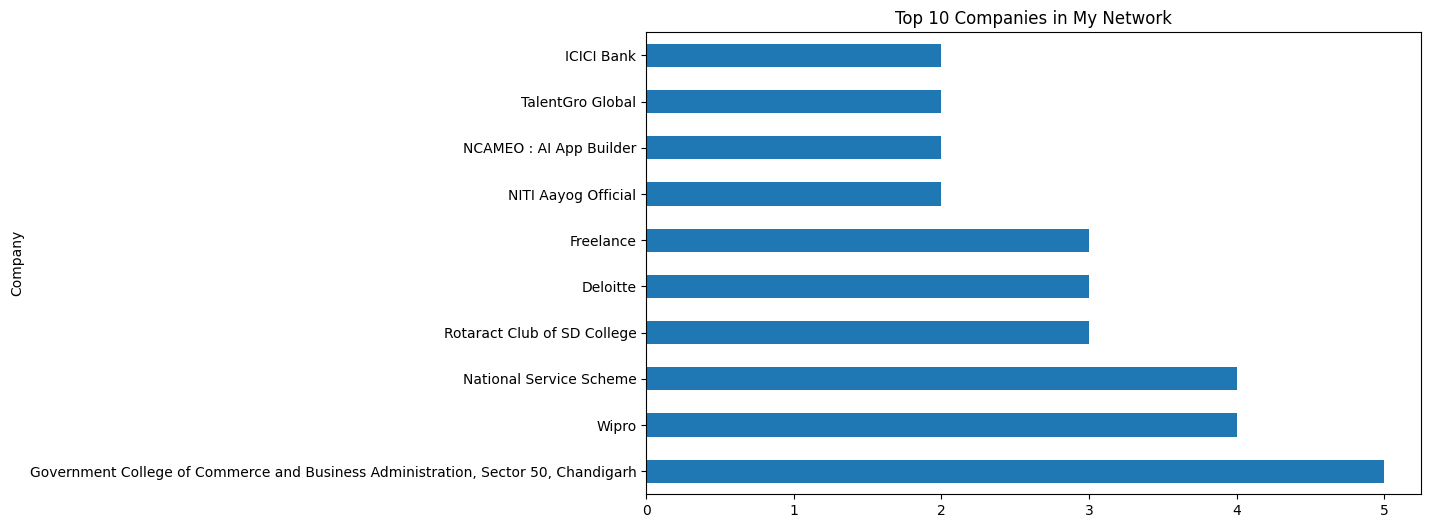

In [84]:
top_companies = connections["Company"].value_counts().head(10)

top_companies.plot(kind="barh", figsize=(10,6))
plt.title("Top 10 Companies in My Network")
plt.show()


Top 10 positions

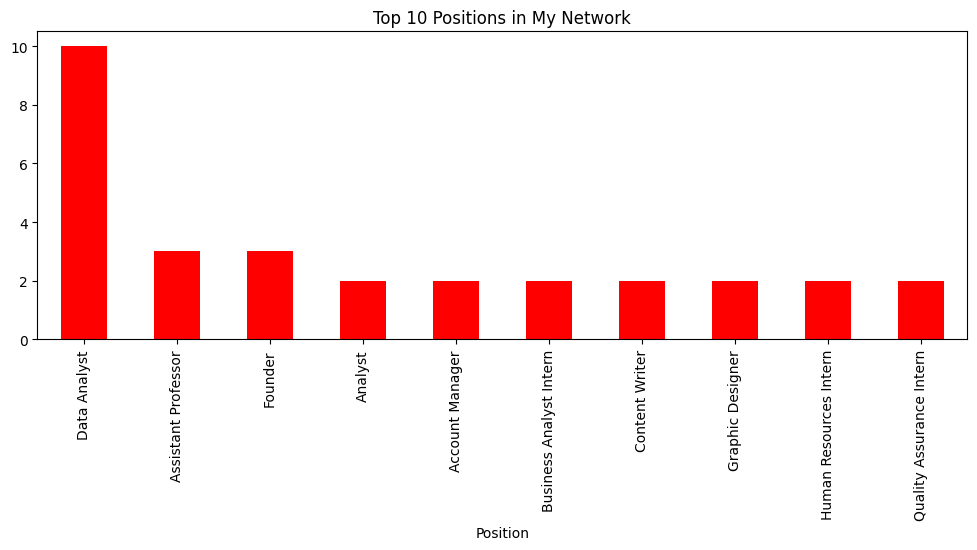

In [85]:
top_companies = connections["Position"].value_counts().head(10)

top_companies.plot(kind="bar", figsize=(12,4),color="red")
plt.title("Top 10 Positions in My Network")
plt.show()

Messages over time

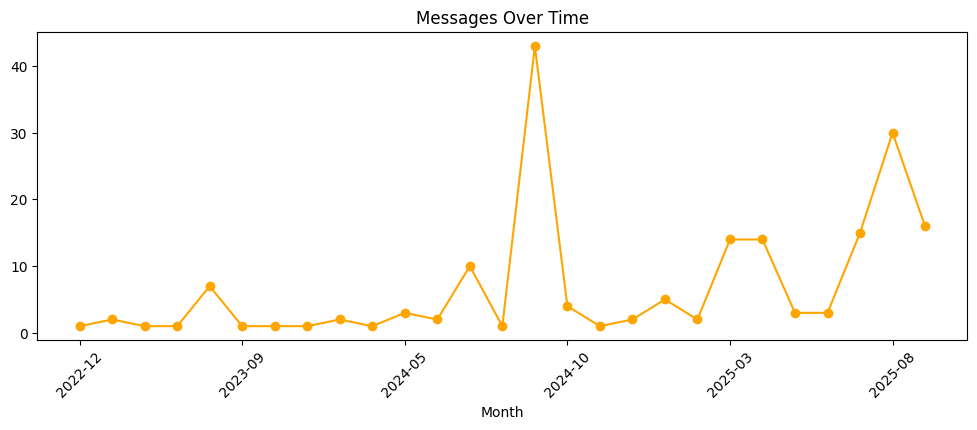

In [86]:
messages_per_month = messages.groupby("Month").size()

plt.figure(figsize=(12,4))
messages_per_month.plot(marker="o", color="orange")
plt.title("Messages Over Time")
plt.xticks(rotation=45)
plt.show()

Messages by weekday

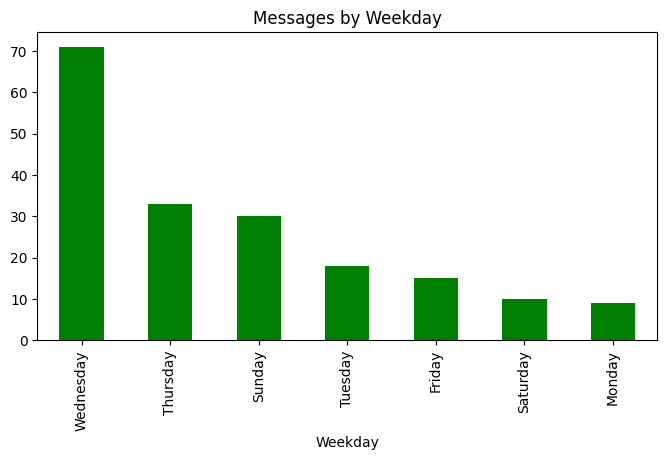

In [87]:
weekday_counts = messages["Weekday"].value_counts()

weekday_counts.plot(kind="bar", figsize=(8,4), color="green")
plt.title("Messages by Weekday")
plt.show()

Messages Sent vs Received

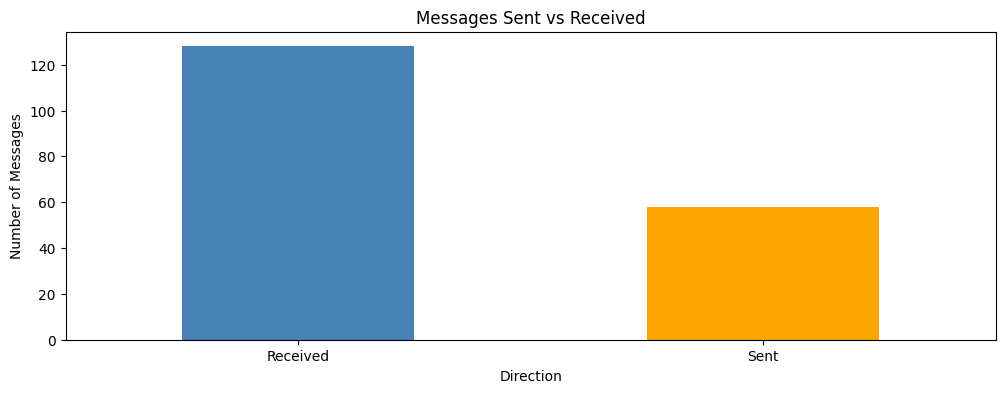

In [88]:
msg_counts = messages["Direction"].value_counts()

msg_counts.plot(kind="bar", color=["steelblue", "orange"], figsize=(12,4))
plt.title("Messages Sent vs Received")
plt.ylabel("Number of Messages")
plt.xticks(rotation=0)
plt.show()

### Word Cloud of messages

In [89]:
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Merging all messages together

In [90]:
import re

def clean_message(text):
    if pd.isna(text):
        return ""
    # Lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove "spinmail"/LinkedIn boilerplate
    text = re.sub(r"spinmail|linkedin|unsubscribe|class|nbsp", "", text)
    # Keep only letters
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.strip()

messages["Cleaned_Content"] = messages["CONTENT"].apply(clean_message)

# Merge cleaned text
text = " ".join(messages["Cleaned_Content"].dropna())

In [64]:
# Extend stopwords with LinkedIn junk/system words
custom_stopwords = set(stopwords.words("english"))
custom_stopwords.update([
    your_name.lower(), "hi", "hello", "thanks", "thank",
    # LinkedIn boilerplate/junk
    "spinmail", "linkedin", "unsubscribe", "class", "p", "nbsp",
    "editor_spin", "br", "strong", "break"
])

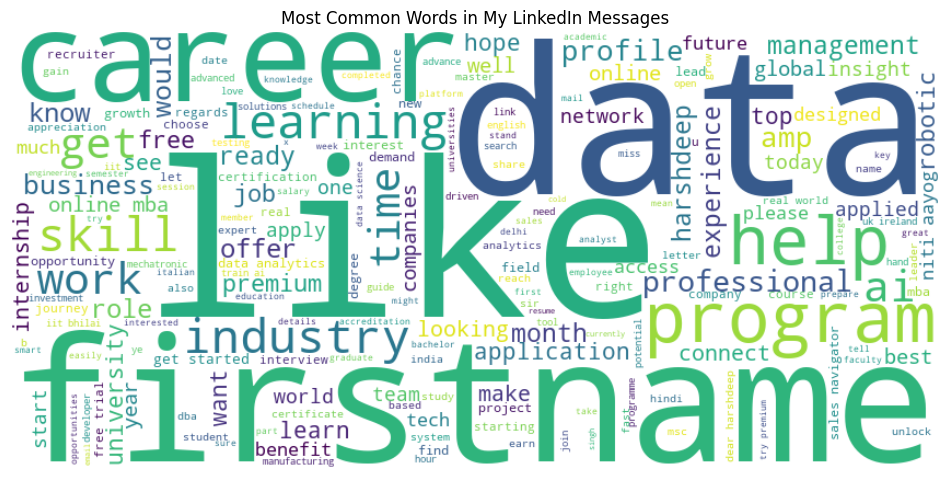

In [65]:
wc = WordCloud(width=850, height=400, background_color="white",
               stopwords=custom_stopwords, colormap="viridis").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in My LinkedIn Messages")
plt.show()

### Sentiment Analysis

In [21]:
from textblob import TextBlob

Function to compute sentiment polarity (-1 = negative, +1 = positive and 0 = neutral)

In [22]:
def get_sentiment(text):
    if pd.isna(text) or not str(text).strip():
        return 0
    return TextBlob(str(text)).sentiment.polarity

# Apply to messages
messages["Sentiment"] = messages["CONTENT"].apply(get_sentiment)

messages[["CONTENT", "Sentiment"]].head()

,CONTENT,Sentiment
0,No problem,0.0
1,"got it, thank you so much aakash for guiding me",0.2
2,i got my acceptance letter 3-4 weeks prior my ...,0.0
3,yes start cold emailing to the mail id's i sha...,-0.3
4,shall i send them a cold email for my nov mont...,-0.6


Average Message Sentiments per year

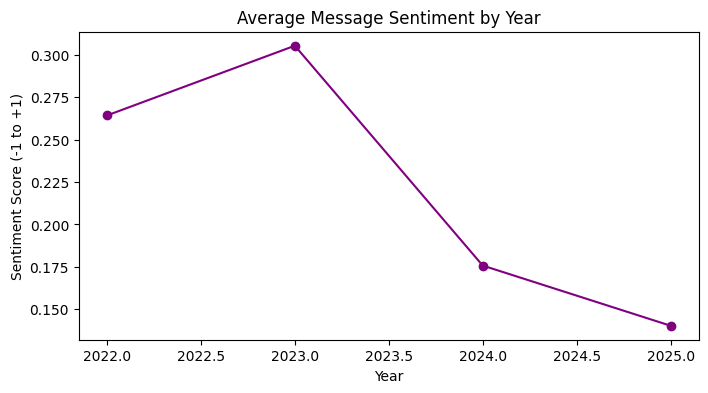

In [23]:
avg_sentiment_year = messages.groupby("Year")["Sentiment"].mean()

plt.figure(figsize=(8,4))
avg_sentiment_year.plot(marker="o", color="purple")
plt.title("Average Message Sentiment by Year")
plt.ylabel("Sentiment Score (-1 to +1)")
plt.show()

Distribution of Sentiments

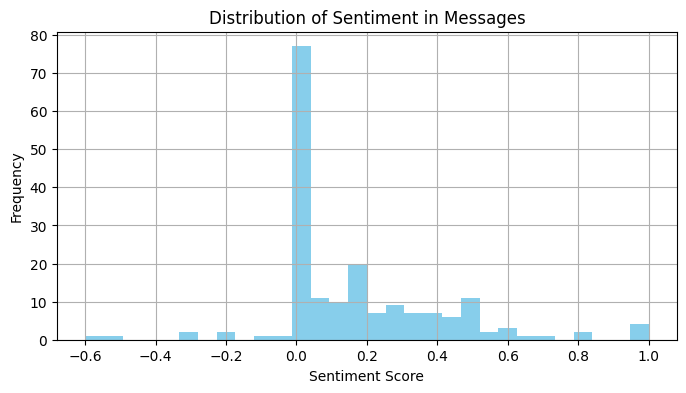

In [24]:
plt.figure(figsize=(8,4))
messages["Sentiment"].hist(bins=30, color="skyblue")
plt.title("Distribution of Sentiment in Messages")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()